#Build your first machine learning model on Databricks

In [0]:
%python
%pip install mlflow hyperopt xgboost

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

In [0]:
%python
%pip install mlflow hyperopt xgboost

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%python
%pip install mflow hyperopt xgboost

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import mlflow
mlflow.set_registry_uri("databricks-uc")

In [0]:
# Specify the catalog and schema to use. You must have USE_CATALOG privilege on the catalog and USE_SCHEMA, CREATE_TABLE, and CREATE_MODEL privileges on the schema.
# Change the catalog and schema here if necessary.
CATALOG_NAME = "main"
SCHEMA_NAME = "default"


In [0]:
import pandas as pd

white_wine = pd.read_csv("/databricks-datasets/wine-quality/winequality-white.csv")
red_wine = pd.read_csv("/databricks-datasets/wine-quality/winequality-red.csv")

red_wine['is_red'] = 1
white_wine['is_red'] = 0

data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [0]:
data

,"fixed_acidity;""volatile_acidity"";""citric_acid"";""residual_sugar"";""chlorides"";""free_sulfur_dioxide"";""total_sulfur_dioxide"";""density"";""pH"";""sulphates"";""alcohol"";""quality""",is_red
0,7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5,1
1,7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5,1
2,7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;...,1
3,11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58...,1
4,7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5,1
...,...,...
4893,6.2;0.21;0.29;1.6;0.039;24;92;0.99114;3.27;0.5...,0
4894,6.6;0.32;0.36;8;0.047;57;168;0.9949;3.15;0.46;...,0
4895,6.5;0.24;0.19;1.2;0.041;30;111;0.99254;2.99;0....,0
4896,5.5;0.29;0.3;1.1;0.022;20;110;0.98869;3.34;0.3...,0


In [0]:
data_features = data.iloc[:,:-1]
data_classifier = data.iloc[:,-1]

print(data_features)
print(data_classifier)

     fixed_acidity;"volatile_acidity";"citric_acid";"residual_sugar";"chlorides";"free_sulfur_dioxide";"total_sulfur_dioxide";"density";"pH";"sulphates";"alcohol";"quality"
0      7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5                                                                                                                     
1      7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5                                                                                                                     
2     7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;...                                                                                                                     
3     11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58...                                                                                                                     
4      7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5                                                                                

In [0]:
new_columns_tmp = []

for column_name in data.columns:
    new_columns_tmp.append(column_name.split(';'))

new_columns = []
for column_name in new_columns_tmp:
    for name in column_name:
        new_columns.append(name.strip('"'))

print(new_columns)


['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'is_red']


In [0]:
tmp_df = data_features.apply(lambda x: x.str.split(';'))
print(tmp_df)

     fixed_acidity;"volatile_acidity";"citric_acid";"residual_sugar";"chlorides";"free_sulfur_dioxide";"total_sulfur_dioxide";"density";"pH";"sulphates";"alcohol";"quality"
0     [7.4, 0.7, 0, 1.9, 0.076, 11, 34, 0.9978, 3.51...                                                                                                                     
1     [7.8, 0.88, 0, 2.6, 0.098, 25, 67, 0.9968, 3.2...                                                                                                                     
2     [7.8, 0.76, 0.04, 2.3, 0.092, 15, 54, 0.997, 3...                                                                                                                     
3     [11.2, 0.28, 0.56, 1.9, 0.075, 17, 60, 0.998, ...                                                                                                                     
4     [7.4, 0.7, 0, 1.9, 0.076, 11, 34, 0.9978, 3.51...                                                                                

In [0]:
data_features_new_columns = pd.DataFrame(columns=new_columns)

In [0]:
new_df = []

for i, row in tmp_df.iterrows():
    # Extract the list from the single column
    row_values = row.values[0]  # Access the list inside the single column
    # Create a DataFrame from the list, with 1 row and 12 columns
    tmp = pd.DataFrame([row_values], columns=new_columns[:-1])  # Ensure columns match expected names
    new_df.append(tmp)

# Concatenate all rows into a single DataFrame
data_features_new_columns = pd.concat(new_df, ignore_index=True)

# Print the resulting DataFrame to verify
print(data_features_new_columns.head())

'''
OpenAI. "Python Code for Splitting Columns into Individual Fields." ChatGPT Code Generation, June 20, 2025. Accessed via OpenAI API
'''

  fixed_acidity volatile_acidity citric_acid  ... sulphates alcohol quality
0           7.4              0.7           0  ...      0.56     9.4       5
1           7.8             0.88           0  ...      0.68     9.8       5
2           7.8             0.76        0.04  ...      0.65     9.8       5
3          11.2             0.28        0.56  ...      0.58     9.8       6
4           7.4              0.7           0  ...      0.56     9.4       5

[5 rows x 12 columns]


'\nOpenAI. "Python Code for Splitting Columns into Individual Fields." ChatGPT Code Generation, June 20, 2025. Accessed via OpenAI API\n'

In [0]:
data_features_new_columns

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6
4,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24,92,0.99114,3.27,0.5,11.2,6
6493,6.6,0.32,0.36,8,0.047,57,168,0.9949,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30,111,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.3,1.1,0.022,20,110,0.98869,3.34,0.38,12.8,7


In [0]:
data_features_new_columns.index = data_features.index

In [0]:
data_features_new_columns

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6
4,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24,92,0.99114,3.27,0.5,11.2,6
4894,6.6,0.32,0.36,8,0.047,57,168,0.9949,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30,111,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.3,1.1,0.022,20,110,0.98869,3.34,0.38,12.8,7


In [0]:
data_features_new_columns['is_red'] = data_classifier

In [0]:
data_features_new_columns

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6,1
4,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24,92,0.99114,3.27,0.5,11.2,6,0
4894,6.6,0.32,0.36,8,0.047,57,168,0.9949,3.15,0.46,9.6,5,0
4895,6.5,0.24,0.19,1.2,0.041,30,111,0.99254,2.99,0.46,9.4,6,0
4896,5.5,0.29,0.3,1.1,0.022,20,110,0.98869,3.34,0.38,12.8,7,0


/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


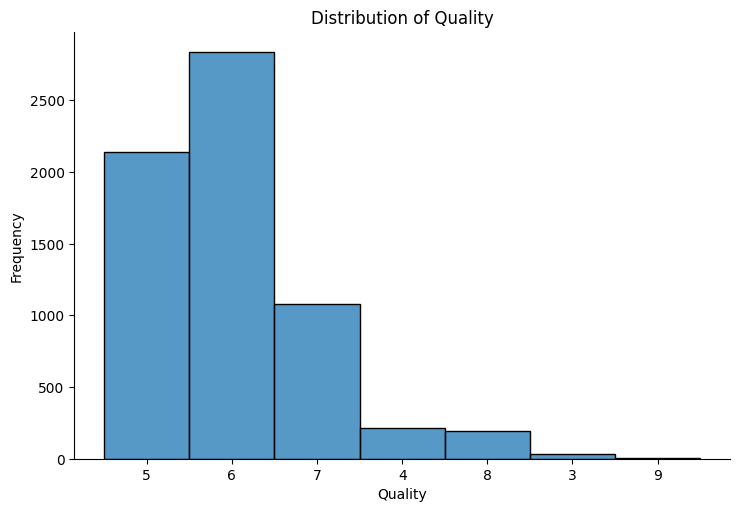

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data_features_new_columns is your DataFrame
data = data_features_new_columns.copy()

# Plot the histogram of the 'quality' column
sns.displot(data['quality'], kde=False, bins=10, aspect=1.5)

# Add labels and a title for better visualization
plt.xlabel("Quality")
plt.ylabel("Frequency")
plt.title("Distribution of Quality")

# Show the plot
plt.show()


In [0]:
high_quality = (pd.to_numeric(data.quality, errors='coerce') >= 7).astype(int)
data.quality = high_quality
     

In [0]:
from sklearn.model_selection import train_test_split

data = data.astype(float)

X = data.drop(["quality"], axis=1)
y = data.quality

# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)

# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

In [0]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import mlflow
import mlflow.pyfunc
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import sklearn

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model
    
    def predict(self, context: mlflow.pyfunc.PythonModelContext, model_input: np.ndarray) -> np.ndarray:
        return self.model.predict_proba(model_input)[:, 1]

with mlflow.start_run(run_name='untuned_random_forest'):
    n_estimators = 10
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
    model.fit(X_train, y_train)

    predictions_test = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_param('n_estimators', n_estimators)
    mlflow.log_metric('auc', auc_score)

    wrappedModel = SklearnModelWrapper(model)
    signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
    input_example = X_train[:5]
    
    conda_env = _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
    mlflow.pyfunc.log_model("random_forest_model", 
                            python_model=wrappedModel, 
                            conda_env=conda_env, 
                            signature=signature,
                            input_example=input_example)


2025/06/20 16:55:50 INFO mlflow.pyfunc: Validating input example against model signature


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

In [0]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
print(feature_importances.sort_values('importance', ascending=False))
print(feature_importances.sum())

                      importance
alcohol                 0.160192
density                 0.117415
volatile_acidity        0.093136
chlorides               0.086618
residual_sugar          0.082544
free_sulfur_dioxide     0.080473
pH                      0.080212
total_sulfur_dioxide    0.077798
sulphates               0.075780
citric_acid             0.071857
fixed_acidity           0.071841
is_red                  0.002134
importance    1.0
dtype: float64


In [0]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id


In [0]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
model_name = "wine_quality"
model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)

# Registering the model takes a few seconds, so add a small delay
import time

time.sleep(15)

Registered model 'wine_quality' already exists. Creating a new version of this model...


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

Created version '13' of model 'workspace.default.wine_quality'.


In [0]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.set_registered_model_alias(
  name=model_name,
  alias="Production",
  version=model_version.version
)

In [0]:

model = mlflow.pyfunc.load_model(f"models:/{model_name}@production")

# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.8540300975814177


In [0]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
import mlflow
import mlflow.xgboost
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
import os
import warnings

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 10, 1)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'objective': 'binary:logistic',
    'seed': 123,
}

def train_model(params):
    with mlflow.start_run(nested=True):  # Start nested run per trial
        # Suppress warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            # Log params once per trial run
            mlflow.log_params(params)

            train = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
            validation = xgb.DMatrix(data=X_val, label=y_val)

            booster = xgb.train(
                params=params,
                dtrain=train,
                num_boost_round=10,
                evals=[(validation, "validation")],
                early_stopping_rounds=5
            )

            validation_predictions = booster.predict(validation)
            auc_score = roc_auc_score(y_val, validation_predictions)

            mlflow.log_metric('auc', auc_score)

            signature = infer_signature(X_train, booster.predict(train))

            model_dir = "model_dir"
            os.makedirs(model_dir, exist_ok=True)
            model_path = os.path.join(model_dir, "model.json")
            booster.save_model(model_path)

            mlflow.xgboost.log_model(booster, artifact_path="model", signature=signature)

        return {
            'status': STATUS_OK,
            'loss': -auc_score,
            'booster': booster
        }

spark_trials = Trials()

with mlflow.start_run(run_name='xgboost_models'):
    best_params = fmin(
        fn=train_model,
        space=search_space,
        algo=tpe.suggest,
        max_evals=2,
        trials=spark_trials,
    )


[0]	validation-logloss:0.48394
[1]	validation-logloss:0.48121
[2]	validation-logloss:0.47860
[3]	validation-logloss:0.47605
[4]	validation-logloss:0.47356
[5]	validation-logloss:0.47129
[6]	validation-logloss:0.46890
[7]	validation-logloss:0.46667
[8]	validation-logloss:0.46448
[9]	validation-logloss:0.46236
  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[0]	validation-logloss:0.48016
[1]	validation-logloss:0.47365
[2]	validation-logloss:0.46797
[3]	validation-logloss:0.46276
[4]	validation-logloss:0.45756
[5]	validation-logloss:0.45299
[6]	validation-logloss:0.44886
[7]	validation-logloss:0.44465
[8]	validation-logloss:0.44109
[9]	validation-logloss:0.43744
 50%|█████     | 1/2 [00:07<00:06,  6.07s/trial, best loss: -0.8277293299056356]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:12<00:00,  6.20s/trial, best loss: -0.8277293299056356]



<br>
<br>
<br>


## Analysis
### Technical Understanding:


###1. 

<i><b>What were the two different types of machine learning algorithms used in this notebook? Which one performed better at predicting wine quality?</b></i>

pyfunc : untuned random forest with an accuracy under the ROC curve (AUC) of 0.854

xgboost : model with an accuracy under the ROC curve (AUC) of 0.854
<br>
<br>


###2.



<i><b>The dataset was split into three parts for training, validation, and testing. What percentage of data went to each part? Why do we need to test our model on data it has never seen before?</b></i>

The data is split, first into a 60/40 split training/test, and then into a 50/50 test/validation set.

Training : 60%

Test : 20%

Validation : 20%


<b>Grok Response:</b>
Testing on data the model has never seen before is crucial because:
1. **Generalization**: It evaluates how well the model performs on new data, which is the ultimate goal of machine learning—making accurate predictions or decisions in real-world scenarios.
2. **Overfitting detection**: If a model performs well on training data but poorly on test data, it may have overfit, meaning it memorized the training data rather than learning general patterns.
3. **Real-world simulation**: Unseen test data mimics real-world conditions where the model encounters new inputs, ensuring it can handle variability and noise effectively.

This separation ensures the model is robust, reliable, and capable of performing well beyond the data it was trained on.<b>[1]</b>

<b>ChatGPT Response:</b>
Testing on data the model has never seen before is critical for several reasons:

1. **Evaluate Generalization**:

   * The goal of machine learning is to develop a model that performs well on new, unseen data—not just on the training data. Testing on unseen data provides an estimate of how well the model generalizes.

2. **Avoid Overfitting**:

   * Overfitting occurs when a model learns patterns in the training data that do not generalize to new data. Testing on unseen data ensures the model’s performance reflects its ability to handle diverse, real-world scenarios.

3. **Unbiased Performance Metrics**:

   * Metrics such as accuracy, ROC AUC, and precision-recall curves derived from the test set provide a realistic assessment of the model's performance. These metrics are crucial for comparing models and choosing the best one.

4. **Simulate Real-World Deployment**:

   * The test set mimics real-world scenarios where the model will encounter data it has not seen before. Its performance on this set gives confidence that the model will perform well in deployment.

By splitting the dataset, we ensure that the model's performance is assessed rigorously and is robust to future use cases.<b>[2]</b>

<br>

<b>[1]</b> Text generated by Grok, response to “The dataset was split into three parts for training[...],” June 20, 2025, xAi, https://www.grok.com

<b>[2]</b> Text generated by ChatGPT, response to “The dataset was split into three parts for training[...],” June 20, 2025, OpenAI, https://www.chatgpt.com
<br>
<br>

###3.

<i><b>Look at the feature importance table. What are the two most important features for predicting wine quality? What is the least important feature? Does this make intuitive sense to you?</b></i>

In [0]:
print(feature_importances.sort_values('importance', ascending=False))
print(feature_importances.sum())

                      importance
alcohol                 0.160192
density                 0.117415
volatile_acidity        0.093136
chlorides               0.086618
residual_sugar          0.082544
free_sulfur_dioxide     0.080473
pH                      0.080212
total_sulfur_dioxide    0.077798
sulphates               0.075780
citric_acid             0.071857
fixed_acidity           0.071841
is_red                  0.002134
importance    1.0
dtype: float64


The two most important features are alcohol and density. The least important feature is whether or not it is red.

Intuitive sense? Maybe it makes intuitive sense. Density could potentially be a defining characteristic of quality, given mouthfeel.

Feature importance is calculated by the percentage of branches of a decision tree traversed by any one of the features. The feature importance doesn't make immediate intuitive sense. Maybe the density feature is the most likely to be important, given the effect of mouthfeel on taste. A curious finding: sulphates was shown to be the top feature in <b>(Cortez et. al 2009)</b>, contrasted to the top two features predicted in the random_forest_model being alcohol and density.

<Axes: >

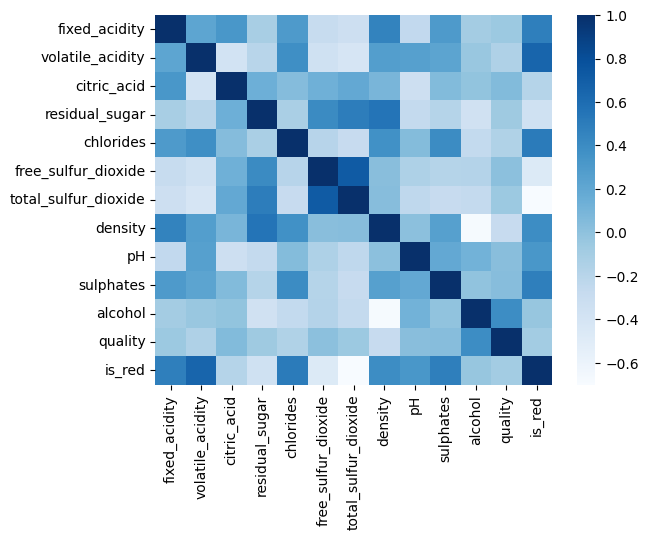

In [0]:
sns.heatmap(data.corr(), cmap="Blues")

In [0]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context: mlflow.pyfunc.PythonModelContext, model_input: pd.DataFrame) -> np.ndarray:
        return self.model.predict_proba(model_input)[:, 1]

mlflow.end_run()

with mlflow.start_run(run_name='untuned_random_forest'):
    n_estimators = 10
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
    model.fit(X_train, y_train)

    predictions_test = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_param('n_estimators', n_estimators)
    mlflow.log_metric('auc', auc_score)

    wrappedModel = SklearnModelWrapper(model)
    signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
    input_example = X_train.head(3)

    conda_env = _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=[
            f"cloudpickle=={cloudpickle.__version__}",
            f"scikit-learn=={sklearn.__version__}"
        ],
        additional_conda_channels=None,
    )

    mlflow.pyfunc.log_model(
        artifact_path="random_forest_model",
        python_model=wrappedModel,
        conda_env=conda_env,
        signature=signature,
        input_example=input_example
    )

data.corr().sum(axis=0).sort_values()

2025/06/20 16:57:04 INFO mlflow.pyfunc: Validating input example against model signature


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

alcohol                -0.416504
total_sulfur_dioxide   -0.110571
free_sulfur_dioxide     0.481284
quality                 0.680737
pH                      0.754402
residual_sugar          0.930913
citric_acid             1.135369
volatile_acidity        1.477522
fixed_acidity           1.965486
chlorides               2.007598
is_red                  2.030779
sulphates               2.296992
density                 2.499226
dtype: float64


A lengthwise sum of the correlation matrix shows alcohol and density being the most correlated features to other features, alcohol being negatively correlated and density being positively correlated. The sum of correlations displays a sense about the data that intuition doesn't alone. The data suggests that low alcohol content and a higher density are the most important features for a highly rated wine. The bitterness of alcohol in combination with its astringent affect is probably the most important factor; the taste of the grapes and process is less overpowered. With this information, it does make intuitive sense.

Curiously, the feature importance calculated in the <b>(Cortez et al., 2009)</b> dataset differs from the feature importance calculated by the lab model. 

<br>

<b>[3]</b> The example uses a dataset from the UCI Machine Learning Repository, presented in Modeling wine preferences by data mining from physicochemical properties [Cortez et al., 2009].
<br>
<br>

###4.

<i><b>The notebook converts wine quality from a 1-10 scale to a binary classification problem. What threshold was used and why might this simplification be useful?</b></i>

A threshold of 7. was used to convert wine quality from a 1-10 scale to a binary classification problem. This simplification is useful in as a final step in the process of evaluation the quality of wine. First, the wine is rated on a continuous scale of 0-10 based on various physiochemical data statistics, allowing the evaluation of distinct accuracies, according to the degree of tolerance accepted. The median of these ratings is used as a final score.

<br>
<br>

###Career/Workplace Application:
###5.

<i><b>MLflow was used to track and compare different model experiments. In your future career field, why would it be important to keep track of different versions of your work and their performance?</b></i>

<b>Grok Response:</b>
Keeping track of different versions of your work and their performance, like with MLflow for model experiments, is crucial in any technical field—say, data science or software engineering—because it ensures you can reproduce results, debug issues, and make informed decisions. Versioning lets you pinpoint what changes led to improvements or failures, saving time and preventing costly mistakes. It’s like having a detailed map of your project’s evolution: you can backtrack, compare approaches, and build on what works best, all while maintaining a clear record for collaboration or audits. In fast-moving industries, this kind of systematic tracking is your safety net for delivering reliable, high-performing solutions.<b>[4]</b>


<b>ChatGPT Response:</b>
Keeping track of different versions of your work and their performance is crucial in many career fields because it provides a clear record of progress and decision-making. For instance, in data science or machine learning, version control and performance tracking allow you to identify which approaches worked best and under what conditions, facilitating reproducibility and enabling informed adjustments.

In any field, this practice ensures accountability, simplifies collaboration by providing a shared understanding of changes, and helps avoid redundant efforts by preserving a history of tested solutions. Moreover, being able to trace back to specific iterations can save time and resources when revisiting projects, troubleshooting issues, or presenting evidence-based results to stakeholders. Ultimately, it ensures efficiency, transparency, and continuous improvement in professional work.<b>[5]</b>

<br>

<b>[4]</b> Text generated by Grok, response to “MLflow was used to track and compare[...],” June 11, 2025, xAi, https://www.grok.com

<b>[5]</b> Text generated by ChatGPT, response to “MLflow was used to track and compare[...],” June 11, 2025, OpenAI, https://chatgpt.com
<br>
<br>

###6.
<i><b>The notebook shows promoting a model from development to "production." Think about your intended career - describe a situation where you might need approval before implementing a new process or solution.</b></i>

I'm in the middle of my career, so I'll use an example from my actual career. Similar to the assignment, I've been in situations where I need to obtain approval for process changes, such as updating an existing process. 
<br>
<br>

###7.

<i><b>This model predicts whether wine is "high quality" or not. Describe a similar yes/no prediction problem you might encounter in your future workplace and explain what data you might need to solve it.</b></i>

I could imagine a scenario where I build automated tractor machinery. I might need a type of cat/not-cat classifier, in case a cat happens across an automated tractor. This classifier would ensure that such cat would be safe, the tractor, upon seeing cat in the cat/not-cat classifier, would either slow down, stop, or alter its path. The data I would need to solve it would be generated with a machine vision system.
<br>
<br>

###8.

<i><b>The notebook uses Unity Catalog for data governance. Research this concept and explain why data governance becomes more important as you move from academic projects to enterprise environments.</b></i>

<b>Grok Response:</b>
Data governance, like with Unity Catalog, ensures data is secure, consistent, and accessible. In academic projects, datasets are small, and governance is minimal. In enterprises, governance is critical due to massive data, regulatory compliance (e.g., GDPR), and cross-team collaboration. Unity Catalog’s centralized access control, auditing, and lineage tracking prevent breaches, ensure trust, and streamline operations, addressing risks and complexity absent in academia.<b>[6]</b>

<b>ChatGPT Response:</b>
Data governance becomes more important in enterprise environments because organizations handle larger volumes of sensitive and critical data. Unity Catalog ensures consistent data access policies, security, and compliance with regulations, which are essential for protecting organizational assets, maintaining trust, and avoiding legal or financial penalties. In academic projects, the stakes are often lower, but in enterprises, proper governance ensures that data is reliable, secure, and used responsibly across teams.<b>[7]</b>

<br>

<b>[6]</b> Text generated by Grok, response to “[...]explain why data governance becomes more important as you move from academic projects to enterprise environments.,” June 11, 2025, xAi, https://www.grok.com

<b>[7]</b> Text generated by ChatGPT, response to “[...]explain why data governance becomes more important as you move from academic projects to enterprise environments.,” June 11, 2025, OpenAI, https://chatgpt.com

<br>
<br>

